# Salary Prediction from LinkedIn Job Postings - Cluster JD attributes

## Setup

In [ ]:
import pandas as pd, numpy as np
import salary
import json
from tqdm import tqdm
from sklearn.metrics.pairwise import cosine_distances
import matplotlib.pyplot as plt, seaborn as sns
from sklearn.cluster import KMeans

In [3]:
sns.set_theme()

## Read Data

In [ ]:
df_jd = pd.read_json('data/combined_row_0_to_34976_extracted_jd.json')

In [5]:
df_jd

,Required_Skills,Educational_Requirements,Experience_Level,Preferred_Qualifications,Compensation_and_Benefits,job_id
0,"Accuracy, adherence to protocols, detail-orien...",Completed sophomore year in college with at le...,N/A,Majoring in Chemistry or Chemical Engineering....,$17.00/hr - $22.50/hr. Not eligible for benefits,3884812895
1,Conduct preemployment psychological evaluation...,Psychologist License and Statement of Qualific...,N/A,"Knowledge of assessing psychological tests, co...","$8,967.00 - $13,356.00/month",3884813011
2,"Knowledge of financial and cost accounting, ac...",Bachelor’s degree in accounting,At least ten years of experience in a financia...,"QuickBooks Online, Bloomerang, WooCommerce kno...",Part-Time Contractor Position $45.00 - $65.00/...,3884813044
3,"Knowledge of safety requirements, conflict res...",High School Diploma or GED,0 – 3 years of experience,N/A,$18.50 per hour,3884813096
4,"Strong communication skills, product knowledge...",N/A,N/A,Highly proficient in Excel and knowledge of Po...,$20.00 - $22.50/hour,3884813122
...,...,...,...,...,...,...
34971,"Project management, leadership, contracts, acc...",College degree required. A valid driver's lice...,5 to 7 years,N/A,N/A,3898167177
34972,"Research and analyze data, anticipate future n...",Bachelor’s degree or related experience,7 years of related experience or Bachelor’s de...,"Excellent skills in Word, Excel, Publisher, Po...",N/A,3898167184
34973,"Proven track record in selling, retail, restau...",N/A,2-4 years,N/A,Base pay $45k-$55k plus average $15k-$25k in u...,3898167200
34974,"AR, financial statement preparation, GL accoun...",N/A,N/A,Payroll and NetSuite experience,Pay roughly around $45-50 per hour,3898167207


## Cluster Education Requirements

In [15]:
sent_transformer = salary.SentenceBertEncoder()

In [24]:
edu_reqs = df_jd['Educational_Requirements']
edu_req_embeddings = sent_transformer.encode(edu_reqs)

Running KMeans for different k values...


100%|██████████| 45/45 [02:35<00:00,  3.46s/it]


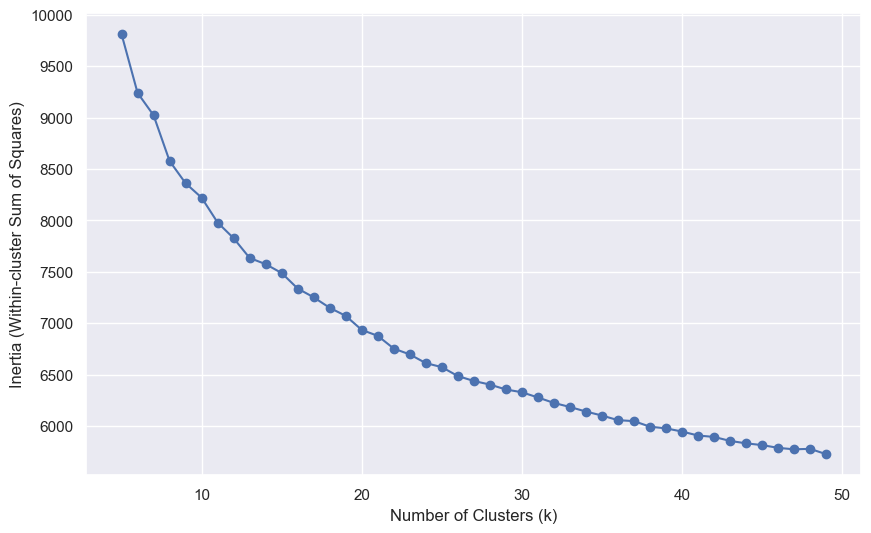

In [54]:
inertia = []
k_values = range(5, 50)
print("Running KMeans for different k values...")
for k in tqdm(k_values):
    kmeans = KMeans(n_clusters=k, random_state=42)
    kmeans.fit(edu_req_embeddings)
    inertia.append(kmeans.inertia_)

plt.figure(figsize=(10, 6))
plt.plot(k_values, inertia, marker='o')
plt.xlabel('Number of Clusters (k)')
plt.ylabel('Inertia (Within-cluster Sum of Squares)')
plt.grid(True)
plt.show()

In [66]:
# Using the elbow method, we (subjectively) choose k = 13
optimal_k = 13

In [67]:
edu_reqs_kmeans = KMeans(n_clusters=optimal_k, random_state=42)
clusters = edu_reqs_kmeans.fit_predict(edu_req_embeddings)


In [68]:
# For each cluster, find the closest title to the centroid
def find_closest_clusters(kmeans: KMeans, embeddings, names):
    cluster_name_map = {}
    for i in range(len(kmeans.cluster_centers_)):
        cluster_indices = np.where(kmeans.labels_ == i)[0]
        cluster_embeddings = embeddings[cluster_indices]
        distances = cosine_distances([kmeans.cluster_centers_[i]], cluster_embeddings)[0]
        closest_index = cluster_indices[np.argmin(distances)]
        cluster_name_map[i] = names[closest_index]

    return cluster_name_map

In [69]:
cluster_name_map = find_closest_clusters(edu_reqs_kmeans, edu_req_embeddings, edu_reqs)
cluster_name_map

{0: 'High school diploma or equivalent',
 1: 'N/A',
 2: "Bachelor's degree or equivalent education and experience.",
 3: "Bachelor's degree in Computer Science, Information Systems, Computer Engineering or related field",
 4: "Bachelor's Degree in Biology, Chemistry or related field",
 5: 'Bachelor’s degree in Engineering or similar technical field',
 6: "Bachelor's Degree",
 7: 'Bachelor’s degree or equivalent desired.',
 8: 'Bachelor’s degree in accounting, finance, or related',
 9: 'Graduate of an accredited program and board certified.',
 10: 'High school diploma/GED/equivalent preferred',
 11: 'Bachelor’s degree in Business Administration, Marketing, Communications, or related field',
 12: "Bachelor's degree in nursing, Registered Nurse licensure"}

## Annotate Clustered JD Attributes

In [70]:
df_jobs_clean_nt = pd.read_csv('data/jobs_clean_nt.csv')
df_jobs_clean_nt

,job_id,title,location,location_state,description,formatted_work_type,formatted_experience_level,remote_allowed,company_industries,company_country,...,company_city,company_description,company_employee_count,normalized_salary,normalized_salary_log10,min_salary,max_salary,med_salary,pay_period,norm_title
0,921716,Marketing Coordinator,"Princeton, NJ",NJ,Job descriptionA leading real estate firm in N...,Full-time,Unknown,0.0,Real Estate,US,...,Jersey City,With years of experience helping local buyers ...,402.0,38480.0,4.585235,17.0,20.0,NaN,HOURLY,Sales Manager
1,1829192,Mental Health Therapist/Counselor,"Fort Collins, CO",CO,"At Aspen Therapy and Wellness , we are committ...",Full-time,Unknown,0.0,NaN,Unknown,...,Unknown,NaN,NaN,83200.0,4.920123,30.0,50.0,NaN,HOURLY,Physical Therapist
2,10998357,Assitant Restaurant Manager,"Cincinnati, OH",OH,The National Exemplar is accepting application...,Full-time,Unknown,0.0,Restaurants,US,...,Mariemont,"In April of 1983, The National Exemplar began ...",15.0,55000.0,4.740363,45000.0,65000.0,NaN,YEARLY,ASSISTANT STORE MANAGER
3,23221523,Senior Elder Law / Trusts and Estates Associat...,"New Hyde Park, NY",NY,Senior Associate Attorney - Elder Law / Trusts...,Full-time,Unknown,0.0,Law Practice,US,...,Lake Success,"Abrams Fensterman, LLP is a full-service law f...",222.0,157500.0,5.197281,140000.0,175000.0,NaN,YEARLY,Associate Attorney
4,35982263,Service Technician,"Burlington, IA",IA,Looking for HVAC service tech with experience ...,Full-time,Unknown,0.0,NaN,Unknown,...,Unknown,NaN,NaN,70000.0,4.845098,60000.0,80000.0,NaN,YEARLY,Service Technician
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
34852,3906265414,Contract Administrator,"Irvine, CA",CA,"Position: Clinical Contracts Analyst, Req#: 63...",Contract,Mid-Senior level,0.0,Staffing and Recruiting,US,...,Natick,"Founded in 2002, TalentBurst is an MBE and JCC...",668.0,83200.0,4.920123,35.0,45.0,NaN,HOURLY,Operations Manager
34853,3906266165,Catering Event Manager,Greater Indianapolis,Unknown,This role handles all the onsite catering and ...,Part-time,Associate,0.0,Staffing and Recruiting,US,...,Indianapolis,Athena Recruiting provides recruitment service...,5.0,57500.0,4.759668,50000.0,65000.0,NaN,YEARLY,Sales Manager
34854,3906266272,Quality Engineer,"Irvine, CA",CA,Position: Quality Engineer I (Complaint Invest...,Contract,Mid-Senior level,0.0,Staffing and Recruiting,US,...,Natick,"Founded in 2002, TalentBurst is an MBE and JCC...",668.0,83200.0,4.920123,30.0,50.0,NaN,HOURLY,Quality Engineer
34855,3906267117,Title IX/Investigations Attorney,"Walnut Creek, CA",CA,Our Walnut Creek office is currently seeking a...,Full-time,Mid-Senior level,0.0,Law Practice,US,...,Fresno,"For more than 30 years, Lozano Smith has serve...",185.0,157500.0,5.197281,120000.0,195000.0,NaN,YEARLY,Associate Attorney


In [72]:
df_jobs_clean_jd = df_jobs_clean_nt.merge(df_jd, on='job_id', how='left')
df_jobs_clean_jd

,job_id,title,location,location_state,description,formatted_work_type,formatted_experience_level,remote_allowed,company_industries,company_country,...,min_salary,max_salary,med_salary,pay_period,norm_title,Required_Skills,Educational_Requirements,Experience_Level,Preferred_Qualifications,Compensation_and_Benefits
0,921716,Marketing Coordinator,"Princeton, NJ",NJ,Job descriptionA leading real estate firm in N...,Full-time,Unknown,0.0,Real Estate,US,...,17.0,20.0,NaN,HOURLY,Sales Manager,Proficiency in Adobe Creative Cloud and Micros...,N/A,1-2 years of marketing and graphic design expe...,"Proficiency in Adobe Creative Cloud (Indesign,...","$18-20/hour, paid time off"
1,1829192,Mental Health Therapist/Counselor,"Fort Collins, CO",CO,"At Aspen Therapy and Wellness , we are committ...",Full-time,Unknown,0.0,NaN,Unknown,...,30.0,50.0,NaN,HOURLY,Physical Therapist,"Conducting intake assessments, developing trea...",Graduate level psychological counseling-relate...,N/A,Experience in EMDR and a parts work perspectiv...,"W2 Employment - commission based, weekly super..."
2,10998357,Assitant Restaurant Manager,"Cincinnati, OH",OH,The National Exemplar is accepting application...,Full-time,Unknown,0.0,Restaurants,US,...,45000.0,65000.0,NaN,YEARLY,ASSISTANT STORE MANAGER,N/A,N/A,N/A,N/A,"Highly competitive wages, healthcare, paid tim..."
3,23221523,Senior Elder Law / Trusts and Estates Associat...,"New Hyde Park, NY",NY,Senior Associate Attorney - Elder Law / Trusts...,Full-time,Unknown,0.0,Law Practice,US,...,140000.0,175000.0,NaN,YEARLY,Associate Attorney,"Estate planning, asset protection, drafting wi...",Juris Doctor degree (J.D.) from an accredited ...,10-15 years of experience,"Experience with Estate Planning, Administratio...","$140,000- $175,000, 401k, Medical, Dental, Lif..."
4,35982263,Service Technician,"Burlington, IA",IA,Looking for HVAC service tech with experience ...,Full-time,Unknown,0.0,NaN,Unknown,...,60000.0,80000.0,NaN,YEARLY,Service Technician,HVAC experience in commercial and industrial e...,Mechanical license,Minimum 5 years,Experience in commerical and industrial equipment,N/A
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
34852,3906265414,Contract Administrator,"Irvine, CA",CA,"Position: Clinical Contracts Analyst, Req#: 63...",Contract,Mid-Senior level,0.0,Staffing and Recruiting,US,...,35.0,45.0,NaN,HOURLY,Operations Manager,NaN,NaN,NaN,NaN,NaN
34853,3906266165,Catering Event Manager,Greater Indianapolis,Unknown,This role handles all the onsite catering and ...,Part-time,Associate,0.0,Staffing and Recruiting,US,...,50000.0,65000.0,NaN,YEARLY,Sales Manager,NaN,NaN,NaN,NaN,NaN
34854,3906266272,Quality Engineer,"Irvine, CA",CA,Position: Quality Engineer I (Complaint Invest...,Contract,Mid-Senior level,0.0,Staffing and Recruiting,US,...,30.0,50.0,NaN,HOURLY,Quality Engineer,NaN,NaN,NaN,NaN,NaN
34855,3906267117,Title IX/Investigations Attorney,"Walnut Creek, CA",CA,Our Walnut Creek office is currently seeking a...,Full-time,Mid-Senior level,0.0,Law Practice,US,...,120000.0,195000.0,NaN,YEARLY,Associate Attorney,NaN,NaN,NaN,NaN,NaN


In [ ]:
# We populate cluster_edu_req with the names of the clusters that Educational_Requirements belong to
embeddings = sent_transformer.encode(df_jobs_clean_jd['Educational_Requirements'].fillna('N/A'))
df_jobs_clean_jd['clustered_edu_req'] = np.vectorize(lambda x: cluster_name_map.get(x))(edu_reqs_kmeans.predict(embeddings))

In [74]:
df_jobs_clean_jd.to_csv('data/jobs_clean_jd.csv', index=False)